In [1]:
import time
import pandas as pd
import numpy as np
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

# Pretty display for notebooks
%matplotlib inline

In [2]:
products = pd.read_csv('Data/amazon_baby.csv', header = 0)
products.dropna(how="any", inplace= True)
print(products.shape)
display(products.head())

# Get first 1000 records for build different models
# products = products.head(1000)
# print(products.shape)


(182384, 3)


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


### Get count for each items

In [3]:
item_count = products.name.value_counts()
item_count = pd.DataFrame({'Item name':item_count.index, 'Count':item_count.values})
# assign column order
item_count = item_count[['Item name', 'Count']]
item_count['Percent'] = item_count['Count']/item_count['Count'].sum()
item_count['Percent'] = item_count['Percent'].map(lambda x: "{0:,.3%}".format(x))
display(item_count.head())
display(item_count.tail())


,Item name,Count,Percent
0,Vulli Sophie the Giraffe Teether,779,0.427%
1,"Simple Wishes Hands-Free Breastpump Bra, Pink,...",560,0.307%
2,Infant Optics DXR-5 2.4 GHz Digital Video Baby...,558,0.306%
3,Baby Einstein Take Along Tunes,545,0.299%
4,"Cloud b Twilight Constellation Night Light, Tu...",517,0.283%


,Item name,Count,Percent
32310,Fisher Price Miracles &amp; MilestonesTM Music...,1,0.001%
32311,"The Original Crumb Chum Bib, Red Dalmations Pa...",1,0.001%
32312,Baby Fanatic 2 pack Pacifiers - Texas A &amp; M,1,0.001%
32313,eli k Sterling Silver Wide Hoop Round Click Ba...,1,0.001%
32314,C.R. Gibson Bless This Child Ceramic Hanging W...,1,0.001%


#### Examining the reviews for most-sold product: 'Vulli Sophie the Giraffe Teether'

In [4]:
def product_review_rating_counter(product_sliced_df):
    rating_count = product_sliced_df.rating.value_counts()
    rating_count = pd.DataFrame({'Value':rating_count.index, 'Count':rating_count.values})
    # assign column order
    rating_count = rating_count[['Value', 'Count']]
    rating_count['Percent'] = rating_count['Count']/rating_count['Count'].sum()
    rating_count['Percent'] = rating_count['Percent'].map(lambda x: "{0:,.3%}".format(x))
    return rating_count


In [5]:
def ratings_chart(ratings_df):
    fig = plt.figure(figsize=(16, 6))
    plt.bar(ratings_df["Value"], ratings_df["Count"])
    fig.suptitle(('Ratings Distribution'), fontsize=18)
    plt.xlabel('Ratings', fontsize=16)
    plt.ylabel('No of Reviews', fontsize=16)
    plt.show()


In [6]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']
print(len(giraffe_reviews))
display(giraffe_reviews.head())

779


,name,review,rating
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5


In [7]:
giraffe_rating_count = product_review_rating_counter(giraffe_reviews)
display(giraffe_rating_count)

,Value,Count,Percent
0,5,531,68.164%
1,4,93,11.938%
2,3,62,7.959%
3,1,56,7.189%
4,2,37,4.750%


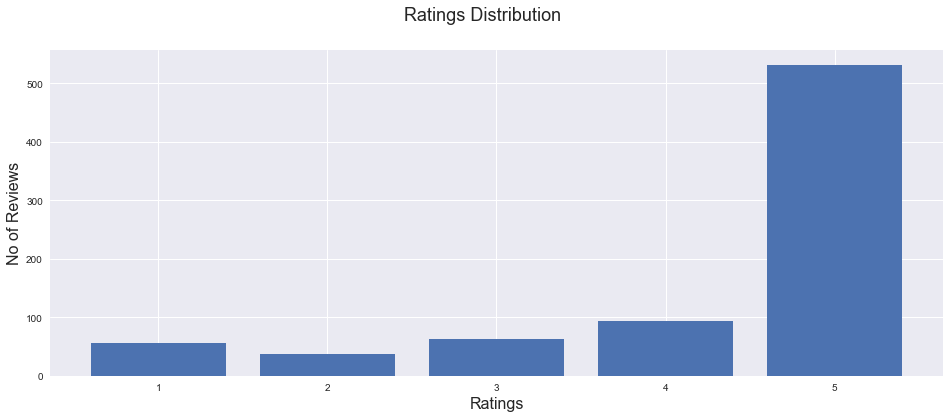

In [8]:
ratings_chart(giraffe_rating_count)

### Clean the review text

In [9]:
def clean_text(text_list):
    """
    Takes in a string of text, then performs the following:
    1. Remove all non alphanumeric chars
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    """
    cleaned_text = list()
    for cur_list in text_list:
        Text = cur_list.lower()
        Text = re.sub('[^a-zA-Z_]', ' ', Text)
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words("english")) + r')\b\s*')
        Text = pattern.sub('', Text)
        cleaned_text.append(Text)
        # tokens = word_tokenize(Text)
        # tokens = [token.strip() for token in tokens]
        # tokens_counts = Counter(tokens)
        # token_list.append(tokens_counts)

    return cleaned_text

In [10]:
#cachedStopWords = stopwords.words("english")
start = time.time()
cleaned_review = clean_text(products.review)
end = time.time()
print("tokenize_text time: {}".format(end - start))
print("cleaned_review len: {}".format(len(cleaned_review)))
products['cleaned_review'] = cleaned_review
display(products.head())

tokenize_text time: 79.253521204
cleaned_review len: 182384


,name,review,rating,cleaned_review
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,flannel wipes ok opinion worth keeping also...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,came early disappointed love planet wise bags...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,soft comfortable warmer looks fit full size ...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,product well worth purchase found anything e...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,kids cried non stop tried ween pacifier found...


### Define what's a positive and a negative sentiment

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment. Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.

In [11]:
#ignore all 3* reviews
products = products[products['rating'] != 3]
print(products.shape)

(165679, 4)


In [12]:
#positive sentiment = 4* or 5* reviews
products['sentiment'] = products['rating'] >=4
products['sentiment'] = products['sentiment'].astype(int)

In [13]:
display(products.head())

,name,review,rating,cleaned_review,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,came early disappointed love planet wise bags...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,soft comfortable warmer looks fit full size ...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,product well worth purchase found anything e...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,kids cried non stop tried ween pacifier found...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,binky fairy came house special gift book help...,1


### Let's train the sentiment classifier

In [14]:
X = products.cleaned_review
y = products.sentiment
display(X.head())
display(y.head())


1    came early disappointed  love planet wise bags...
2    soft comfortable warmer looks   fit full size ...
3    product well worth purchase   found anything e...
4    kids cried non stop tried ween pacifier  found...
5    binky fairy came house  special gift book help...
Name: cleaned_review, dtype: object

1    1
2    1
3    1
4    1
5    1
Name: sentiment, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print("Total Observations: {}".format(products.shape))
print("X_train Observations: {}".format(X_train.shape))
print("X_test Observations: {}".format(X_test.shape))
print("y_train Observations: {}".format(y_train.shape))
print("y_test Observations: {}".format(y_test.shape))


Total Observations: (165679, 5)
X_train Observations: (132543,)
X_test Observations: (33136,)
y_train Observations: (132543,)
y_test Observations: (33136,)


### Transform cleaned_review into Features

In [16]:
vect = CountVectorizer(binary=True)
X_train_vect = vect.fit_transform(X_train)
# X_train_vect = X_train_vect.toarray()


In [17]:
counts = products.sentiment.value_counts()
print(counts)

print("Predicting positive: {:.2f}% accuracy".format((counts[1] * 100) / sum(counts)))
print("Predicting negative: {:.2f}% accuracy".format((counts[0] * 100) / sum(counts)))


1    139318
0     26361
Name: sentiment, dtype: int64
Predicting positive: 84.00% accuracy
Predicting negative: 15.00% accuracy


We can see from above, we have more positives than negatives, making our dataset imbalanced.
By calculating if our model only chose to predict positive, the larger class, we would get a 84% accuracy. This means that in our binary classification model, where random chance is 50%, a 84% accuracy may tell us much. We would definitely want to look at precision and recall more than accuracy.

We can balance our data by using a form of oversampling called SMOTE. SMOTE looks at the minor class, and creates new, synthetic training examples.

In [18]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

In [19]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))


[(0, 111427), (1, 111427)]


### Naive Bayes

In [20]:
nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
nb.score(X_train_res, y_train_res)


0.90410313478779825

In [21]:
X_test_vect = vect.transform(X_test)
y_pred = nb.predict(X_test_vect)
print(y_pred[:3])

[1 1 1]


In [22]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, y_pred)))


Accuracy: 89.52%
F1 Score: 93.65
Confusion Matrix:
[[ 4064  1181]
 [ 2291 25600]]


### Cross Validation

In [23]:
X = products.cleaned_review
y = products.sentiment

ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
    # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("Average accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Average F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("Average Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 89.55%
Average F1 score across folds: 93.67%
Average Confusion Matrix across folds: 
 [[ 4056  1222]
 [ 2241 25616]]


### Let's Plot our Results

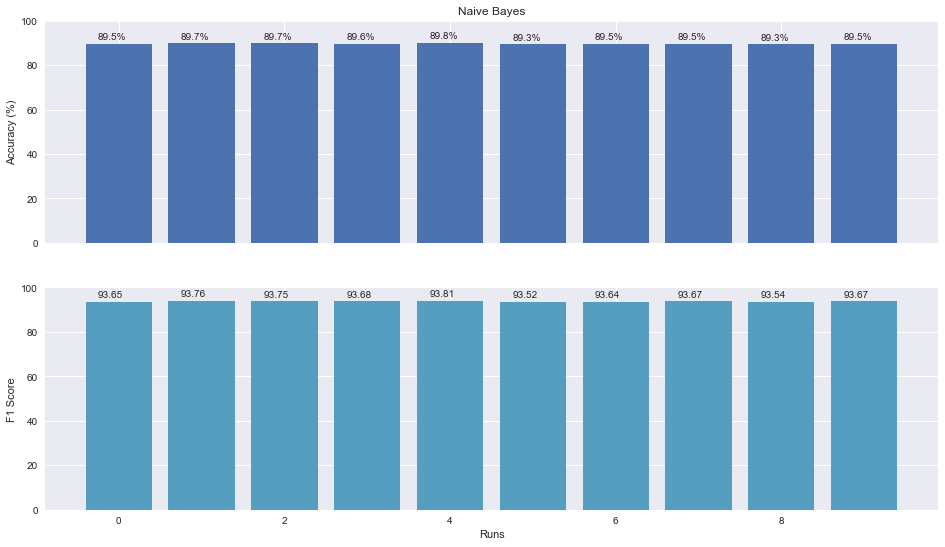

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()

### Other Classification Algorithms in scikit-learn

In [ ]:
X = products.cleaned_review
y = products.sentiment

cv = ShuffleSplit(n_splits=20, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

sm = SMOTE()

# Init a dictionary for storing results of each run for each model
results = {
    model.__class__.__name__: {
        'accuracy': [], 
        'f1_score': [],
        'confusion_matrix': []
    } for model in models
}

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)

    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)

    for model in models:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_vect)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        results[model.__class__.__name__]['accuracy'].append(acc)
        results[model.__class__.__name__]['f1_score'].append(f1)
        results[model.__class__.__name__]['confusion_matrix'].append(cm)


In [ ]:
for model, d in results.items():
    avg_acc = sum(d['accuracy']) / len(d['accuracy']) * 100
    avg_f1 = sum(d['f1_score']) / len(d['f1_score']) * 100
    avg_cm = sum(d['confusion_matrix']) / len(d['confusion_matrix'])
    
    slashes = '-' * 30
    model_summary = "{}\n{}\n" \
    "Avg. Accuracy: {:.2f}%\n" \
    "Avg. F1 Score: {:.2f}\n" \
    "Avg. Confusion Matrix:\n{}\n".format(model, slashes, avg_acc, avg_f1, avg_cm)

    print(model_summary)


In [ ]:
X = products.cleaned_review
y = products.sentiment

cv = ShuffleSplit(n_splits=10, test_size=0.2)

models = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegression(),
    SGDClassifier(),
    LinearSVC(),
    RandomForestClassifier(),
    MLPClassifier()
]

m_names = [m.__class__.__name__ for m in models]

models = list(zip(m_names, models))
vc = VotingClassifier(estimators=models)

sm = SMOTE()

# No need for dictionary now
accs = []
f1s = []
cms = []

for train_index, test_index in cv.split(X):
    X_train, X_test  = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_vect = vect.fit_transform(X_train)    
    X_test_vect = vect.transform(X_test)
    
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    vc.fit(X_train_res, y_train_res)
    
    y_pred = vc.predict(X_test_vect)
    
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))


In [ ]:
print("Voting Classifier")
print("-" * 30)
print("Avg. Accuracy: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("Avg. F1 Score: {:.2f}".format(sum(f1s) / len(f1s) * 100))
print("Confusion Matrix:\n{}".format(sum(cms) / len(cms)))
